In [202]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.font_manager as fm
from textwrap import wrap


prop = fm.FontProperties(fname='../plots/arial.ttf')

plt.rcParams['ps.useafm'] = True
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

from statsmodels.stats.multitest import multipletests

import sys
import os

sys.path.append(os.path.relpath("../../huygens"))
sys.path.append(os.path.relpath("../../galileo"))
import galileo as gal
import huygens as huy

# Define experiments

In [203]:
with open("experiments.json","r") as f:
    exp = json.load(f)
    
    experiments = exp["experiments"]
    experiment_ids = exp["experiment_ids"]
    display_names = exp["display_names"]
    display_groups = exp["display_groups"]


# Load TPMS and sleuth results

In [182]:
kallisto_sleuth_path = "../data/processed/kallisto_sleuth_merge/"

rpl22_oe_genes = pd.read_csv(kallisto_sleuth_path + "rpl22_oe_genes.txt", sep="\t", index_col=0)
rpl22l1_oe_genes = pd.read_csv(kallisto_sleuth_path + "rpl22l1_oe_genes.txt", sep="\t", index_col=0)
rpl22l1_kd1_genes = pd.read_csv(kallisto_sleuth_path + "rpl22l1_kd1_genes.txt", sep="\t", index_col=0)
rpl22l1_kd2_genes = pd.read_csv(kallisto_sleuth_path + "rpl22l1_kd2_genes.txt", sep="\t", index_col=0)
rpl22_ko1_genes = pd.read_csv(kallisto_sleuth_path + "rpl22_ko1_genes.txt", sep="\t", index_col=0)
rpl22_ko2_genes = pd.read_csv(kallisto_sleuth_path + "rpl22_ko2_genes.txt", sep="\t", index_col=0)

rpl22_oe_transcripts = pd.read_csv(kallisto_sleuth_path + "rpl22_oe_transcripts.txt", sep="\t", index_col=0)
rpl22l1_oe_transcripts = pd.read_csv(kallisto_sleuth_path + "rpl22l1_oe_transcripts.txt", sep="\t", index_col=0)
rpl22l1_kd1_transcripts = pd.read_csv(kallisto_sleuth_path + "rpl22l1_kd1_transcripts.txt", sep="\t", index_col=0)
rpl22l1_kd2_transcripts = pd.read_csv(kallisto_sleuth_path + "rpl22l1_kd2_transcripts.txt", sep="\t", index_col=0)
rpl22_ko1_transcripts = pd.read_csv(kallisto_sleuth_path + "rpl22_ko1_transcripts.txt", sep="\t", index_col=0)
rpl22_ko2_transcripts = pd.read_csv(kallisto_sleuth_path + "rpl22_ko2_transcripts.txt", sep="\t", index_col=0)

# Differential expression

In [183]:
def as_si(x, ndp):
    """
    Convert a number to scientific notation

    Parameters
    ----------
    x : float
        number to convert
    ndp: float
        number of decimal places

    Returns
    -------
    x_si : string
        x formatted in scientific notation
    """

    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    x_si = r'{m:s} × $10^{{{e:d}}}$'.format(m=m, e=int(e))

    return x_si

In [184]:
def three_bars(annotation_id, experiment_id_1, experiment_id_2, diff_results_1, diff_results_2, ax=None, xlabel=None, ylabel=None):

    if ax is None:
        ax = plt.subplot(111)

    if xlabel is None:
        xlabel = experiment_id_1

    if ylabel is None:
        ylabel = "mRNA expression, log2(TPM + 1)"

    # get experiment controls and treatments
    select_abundance_1 = diff_results_1.loc[annotation_id]
    select_abundance_2 = diff_results_2.loc[annotation_id]

    controls = experiments[experiment_id_1][0]
    treatments_1 = experiments[experiment_id_1][1]
    treatments_2 = experiments[experiment_id_2][1]

    # extract control and treatment values
    control_values = np.log2(select_abundance_1[controls].astype(np.float64)+1)
    treatment_1_values = np.log2(
        select_abundance_1[treatments_1].astype(np.float64)+1)
    treatment_2_values = np.log2(
        select_abundance_2[treatments_2].astype(np.float64)+1)

    control_mean = np.mean(control_values)
    treatment_1_mean = np.mean(treatment_1_values)
    treatment_2_mean = np.mean(treatment_2_values)

    # draw bars based on means
    offset = 0.05
    width = 0.4

    control_rect = Rectangle([offset, 0],
                             width,
                             control_mean,
                             color=control_color,
                             alpha=1,
                             linewidth=0,
                             zorder=-100
                             )
    ax.add_patch(control_rect)

    treatment_1_rect = Rectangle([0.5+offset, 0],
                               width,
                               treatment_1_mean,
                               color=treatment_color,
                               alpha=1,
                               linewidth=0,
                               zorder=-100
                               )
    ax.add_patch(treatment_1_rect)
    
    treatment_2_rect = Rectangle([1+offset, 0],
                               width,
                               treatment_2_mean,
                               color=treatment_color,
                               alpha=1,
                               linewidth=0,
                               zorder=-100
                               )
    ax.add_patch(treatment_2_rect)

    # draw the points themselves
    ax.scatter([0.25-width/4, 0.25, 0.25+width/4],
               control_values,
               color="white",
               linewidth=1,
               s=32,
               edgecolor=control_color
               )
    ax.scatter([0.75-width/4, 0.75, 0.75+width/4],
               treatment_1_values,
               color="white",
               linewidth=1,
               s=32,
               edgecolor=treatment_color
               )
    ax.scatter([1.25-width/4, 1.25, 1.25+width/4],
               treatment_2_values,
               color="white",
               linewidth=1,
               s=32,
               edgecolor=treatment_color
               )

    # figure formatting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0.25, 0.75, 1.25])
    ax.set_xticklabels(["", ""])
    ax.set_xlabel(xlabel, rotation=45)
    ax.set_ylabel(ylabel)

    # space out axes
    ax.spines['bottom'].set_position(('axes', 0))
    ax.spines['left'].set_position(('axes', -0.25))

    # set y minimum to 0
    plt.ylim(-0.01)

    y_max = max(list(control_values)+list(treatment_1_values)+list(treatment_2_values))

    qval_1 = select_abundance_1["qval"]
    qval_2 = select_abundance_2["qval"]

    if not np.isnan(qval_1):

        if qval_1 < 0.001:
            compare_text = "**"
        elif qval_1 < 0.01:
            compare_text = "*"
        else:
            compare_text = "n.s"

        ax.text(0.75,
                treatment_1_mean+1,
                compare_text,
                ha="center",
                fontsize=12,
                )
        
    if not np.isnan(qval_2):

        if qval_2 < 0.001:
            compare_text = "**"
        elif qval_2 < 0.01:
            compare_text = "*"
        else:
            compare_text = "n.s"

        ax.text(1.25,
                treatment_2_mean+1,
                compare_text,
                ha="center",
                fontsize=12,
                )

    return ax, y_max

(<matplotlib.axes._subplots.AxesSubplot at 0x15185c910>, 10.169049306625007)

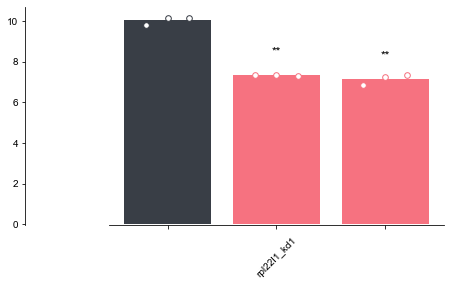

In [186]:
three_bars("ENSG00000163584",
           "rpl22l1_kd1",
           "rpl22l1_kd2",
           sh704_genes,
           sh705_genes,
           ylabel="")

In [238]:
control_color = "#393e46"
treatment_color = "#f67280"
alpha = 0.5


def bars(annotation_id, experiment_id, diff_results, ax=None, xlabel=None, ylabel=None):

    if ax is None:
        ax = plt.subplot(111)

    if xlabel is None:
        xlabel = experiment_id

    if ylabel is None:
        ylabel = "mRNA expression, log2(TPM + 1)"

    # get experiment controls and treatments
    select_abundance = diff_results.loc[annotation_id]

    controls = experiments[experiment_id][0]
    treatments = experiments[experiment_id][1]

    # extract control and treatment values
    control_values = np.log2(select_abundance[controls].astype(np.float64)+1)
    treatment_values = np.log2(
        select_abundance[treatments].astype(np.float64)+1)

    control_mean = np.mean(control_values)
    treatment_mean = np.mean(treatment_values)

    # draw bars based on means
    offset = 0.05
    width = 0.4

    control_rect = Rectangle([offset, 0],
                             width,
                             control_mean,
                             color=control_color,
                             alpha=1,
                             linewidth=0,
                             zorder=-100
                             )
    ax.add_patch(control_rect)

    treatment_rect = Rectangle([0.5+offset, 0],
                               width,
                               treatment_mean,
                               color=treatment_color,
                               alpha=1,
                               linewidth=0,
                               zorder=-100
                               )
    ax.add_patch(treatment_rect)

    # draw the points themselves
    ax.scatter([0.25-width/4, 0.25, 0.25+width/4],
               control_values,
               color="white",
               linewidth=1,
               s=32,
               edgecolor=control_color
               )
    ax.scatter([0.75-width/4, 0.75, 0.75+width/4],
               treatment_values,
               color="white",
               linewidth=1,
               s=32,
               edgecolor=treatment_color
               )

    # figure formatting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0.25, 0.75])
    ax.set_xticklabels(["", ""])
    ax.set_xlabel(xlabel, rotation=45)
    ax.set_ylabel(ylabel)

    # space out axes
    ax.spines['bottom'].set_position(('axes', 0))
    ax.spines['left'].set_position(('axes', -0.25))

    # set y minimum to 0
    plt.ylim(-0.01)

    y_max = max(list(control_values)+list(treatment_values))

    qval = select_abundance["qval"]

    if not np.isnan(qval):

        if qval < 0.001:
            compare_text = "**"
        elif qval < 0.01:
            compare_text = "*"
        else:
            compare_text = "n.s"

        ax.text(0.5,
                0.9,
                compare_text,
                ha="center",
                fontsize=12,
                transform=ax.transAxes
                )

    return ax, y_max


def all_bars(annotation_id, annotation_type, legend=False):
    
    plt.figure(figsize=(4, 2))

    axes_widths = [2,2,3,3]
    total_width = sum(axes_widths)

    cumulative_widths = [sum(axes_widths[:x]) for x in range(len(axes_widths))]

    axes = [plt.subplot2grid((1,total_width), (0,cumulative_widths[x]),
                             colspan=axes_widths[x]) for x in range(len(axes_widths))]

    maxes = []

    if annotation_type == "transcript":
        sleuth_sets = [rpl22_oe_transcripts,
                       rpl22l1_oe_transcripts,
                       [rpl22l1_kd1_transcripts,
                        rpl22l1_kd2_transcripts],
                       [rpl22_ko1_transcripts,
                        rpl22_ko2_transcripts]
                       ]

    elif annotation_type == "gene":
        sleuth_sets = [rpl22_oe_genes,
                       rpl22l1_oe_genes,
                       [rpl22l1_kd1_genes,
                        rpl22l1_kd2_genes],
                       [rpl22_ko1_genes,
                        rpl22_ko2_genes]
                       ]

    elif annotation_type == "splicing":
        sleuth_sets = [rpl22_oe_rmats,
                       rpl22l1_oe_rmats,
                       [rpl22l1_kd1_rmats,
                        rpl22l1_kd2_rmats],
                       [rpl22_ko1_rmats,
                        rpl22_ko2_rmats]
                       ]

    for sleuth_idx, sleuth_set in enumerate(sleuth_sets[:2]):
        ax = axes[sleuth_idx]

        ax, y_max = bars(annotation_id,
                         experiment_ids[sleuth_idx],
                         sleuth_set,
                         ax=ax,
                         ylabel="")

        maxes.append(y_max)

        if sleuth_idx > 0:

            ax.spines["left"].set_visible(False)
            ax.tick_params(axis='y', which='both', right=False,
                           left=False, labelleft=False)
            
        ax.set_ylim(0)

        ax.set_xticklabels(display_groups[sleuth_idx], rotation=45, ha="right")
        ax.set_xlabel("")

    for sleuth_idx, sleuth_set in enumerate(sleuth_sets[2:]):
        ax = axes[2+sleuth_idx]
        
        ax, y_max = three_bars(annotation_id,
                               experiment_ids[2+sleuth_idx*2],
                               experiment_ids[2+sleuth_idx*2+1],
                               sleuth_set[0],
                               sleuth_set[1],
                               ax=ax,
                               ylabel="")

        maxes.append(y_max)

        ax.spines["left"].set_visible(False)
        ax.tick_params(axis='y', which='both', right=False,
                       left=False, labelleft=False)
        
        ax.set_ylim(0)

        ax.set_xticklabels(display_groups[2+sleuth_idx], rotation=45, ha="right")
        ax.set_xlabel("")

    if annotation_type == "transcript" or annotation_type == "gene":
        axes[0].set_ylabel("mRNA expression, log2(TPM+1)")

    elif annotation_type == "splicing":
        axes[0].set_ylabel("Exon inclusion proportion")

    y_max = max(maxes)
    
    for ax in axes:
        ax.set_ylim(0,y_max*1.25)
        
    plt.subplots_adjust(wspace=0.25)

    if legend:

        legend_background = "#eaeaea"

        legend_elements = [Patch(label='Control',
                                 color=control_color, alpha=1),
                           Patch(label='Treatment',
                                 color=treatment_color, alpha=1)]

        legend = plt.legend(handles=legend_elements,
                            loc='upper left', bbox_to_anchor=(1, 1),)
        frame = legend.get_frame()
        frame.set_facecolor(legend_background)
        frame.set_edgecolor(legend_background)

    return axes

In [256]:
rpl22_ko1_transcripts[rpl22_ko1_transcripts["hgnc_gene"]=="MDM4"]

,target_id,ens_gene,hgnc_gene,entrez_gene,duplicate_transcript,pval,qval,b,se_b,mean_obs,...,NCIH2110_GFP_3,NCIH2110_RPL22-1A1_1,NCIH2110_RPL22-1A1_2,NCIH2110_RPL22-1A1_3,control_median,treatment_median,median_foldchange,-log_pval,treatment_increase,signed_pval
ENST00000470797,5719,ENSG00000198625,MDM4,4194,False,0.657470,0.999744,0.396486,0.894176,2.220007,...,0.732926,0.410186,1.592350,2.268220,0.767217,1.592350,2.075488,0.182124,1,0.182124
ENST00000367182,5720,ENSG00000198625,MDM4,4194,False,0.115061,0.999744,0.215578,0.136801,6.255046,...,3.114720,4.717300,3.507970,4.073320,3.400980,4.073320,1.197690,0.939071,1,0.939071
ENST00000463049,5721,ENSG00000198625,MDM4,4194,False,0.673741,0.999744,0.822563,1.953743,2.601961,...,0.402319,0.763880,1.688440,0.005257,0.342356,0.763880,2.231245,0.171507,1,0.171507
ENST00000470908,5722,ENSG00000198625,MDM4,4194,False,0.021822,0.999744,-2.868944,1.250933,1.360225,...,2.017300,0.310265,0.000000,0.000000,2.017300,0.000000,0.000000,1.661096,-1,-1.661096
ENST00000507825,5723,ENSG00000198625,MDM4,4194,False,0.665802,0.999744,-0.456603,1.057155,1.737425,...,0.787141,1.451050,0.328482,0.170462,0.752830,0.328482,0.436330,0.176655,-1,-0.176655
ENST00000454264,5724,ENSG00000198625,MDM4,4194,False,0.021822,0.999744,2.899523,1.264264,1.314529,...,0.128907,0.708757,1.074780,0.850024,0.000000,0.850024,inf,1.661101,1,1.661101
ENST00000391947,5725,ENSG00000198625,MDM4,4194,False,0.572704,0.999744,0.436099,0.773123,3.457294,...,2.869980,1.301600,1.555780,6.434750,2.646920,1.555780,0.587770,0.242070,-1,-0.242070
ENST00000462012,63768,ENSG00000198625,MDM4,4194,False,0.997842,0.999789,-0.002896,1.070402,1.500950,...,1.082680,0.195621,2.152890,1.094360,0.745551,1.094360,1.467854,0.000938,1,0.000938


In [257]:
rpl22_ko2_transcripts[rpl22_ko2_transcripts["hgnc_gene"]=="MDM4"]

,target_id,ens_gene,hgnc_gene,entrez_gene,duplicate_transcript,pval,qval,b,se_b,mean_obs,...,NCIH2110_GFP_3,NCIH2110_RPL22-4A1_1,NCIH2110_RPL22-4A1_2,NCIH2110_RPL22-4A1_3,control_median,treatment_median,median_foldchange,-log_pval,treatment_increase,signed_pval
ENST00000470797,5701,ENSG00000198625,MDM4,4194,False,0.894491,0.999972,0.113998,0.859559,2.120899,...,0.732926,0.318772,1.470830,1.380900,0.767217,1.380900,1.799882,0.048424,1,0.048424
ENST00000367182,5702,ENSG00000198625,MDM4,4194,False,0.023855,0.999972,0.240855,0.106599,6.312702,...,3.114720,4.288490,3.803090,4.916090,3.400980,4.288490,1.260957,1.622419,1,1.622419
ENST00000463049,5703,ENSG00000198625,MDM4,4194,False,0.564107,0.999972,-1.209380,2.096882,1.621567,...,0.402319,0.000000,1.004690,0.000034,0.342356,0.000034,0.000098,0.248638,-1,-0.248638
ENST00000470908,5704,ENSG00000198625,MDM4,4194,False,0.074303,0.999972,-2.275781,1.275129,1.700464,...,2.017300,0.000000,2.282100,0.000000,2.017300,0.000000,0.000000,1.128996,-1,-1.128996
ENST00000367180,5705,ENSG00000198625,MDM4,4194,False,0.307113,0.999972,1.055155,1.033151,1.514002,...,1.436930,1.516730,2.514780,1.021390,0.314707,1.516730,4.819499,0.512702,1,0.512702
ENST00000507825,5706,ENSG00000198625,MDM4,4194,False,0.737685,0.999972,0.262432,0.783565,2.138917,...,0.787141,1.157380,0.845331,0.995662,0.752830,0.995662,1.322559,0.132129,1,0.132129
ENST00000391947,5707,ENSG00000198625,MDM4,4194,False,0.666732,0.999972,-0.403840,0.937771,3.081182,...,2.869980,0.461736,0.823757,2.744380,2.646920,0.823757,0.311213,0.176049,-1,-0.176049


In [258]:
rpl22_ko2_transcripts[rpl22_ko2_transcripts["hgnc_gene"]=="RPL22L1"]

,target_id,ens_gene,hgnc_gene,entrez_gene,duplicate_transcript,pval,qval,b,se_b,mean_obs,...,NCIH2110_GFP_3,NCIH2110_RPL22-4A1_1,NCIH2110_RPL22-4A1_2,NCIH2110_RPL22-4A1_3,control_median,treatment_median,median_foldchange,-log_pval,treatment_increase,signed_pval
ENST00000295830,1,ENSG00000163584,RPL22L1,200916,False,1.290557e-56,8.376874e-52,2.896048,0.182654,5.508186,...,2.11737,40.067200,28.1098,42.356100,2.11737,40.067200,18.923098,55.889223,1,55.889223
ENST00000463836,5,ENSG00000163584,RPL22L1,200916,False,7.615356e-11,9.886102e-07,3.940224,0.605442,5.613982,...,11.77760,540.061000,521.6860,440.915000,11.77760,521.686000,44.294763,10.118310,1,10.118310
ENST00000466674,12,ENSG00000163584,RPL22L1,200916,False,4.672376e-06,2.527327e-02,2.515943,0.549454,4.594711,...,2.29307,53.898100,71.7685,113.997000,7.24723,71.768500,9.902887,5.330462,1,5.330462
ENST00000475836,26620,ENSG00000163584,RPL22L1,200916,False,8.224270e-02,9.999724e-01,-0.394114,0.226786,5.026632,...,32.39590,34.011700,18.8326,23.904400,34.86690,23.904400,0.685590,1.084903,-1,-1.084903
ENST00000494771,26621,ENSG00000163584,RPL22L1,200916,False,1.696118e-01,9.999724e-01,-1.612162,1.173803,1.510163,...,2.28702,0.665155,0.0000,0.744969,2.10666,0.665155,0.315739,0.770544,-1,-0.770544


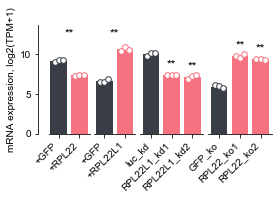

In [239]:
all_bars("ENSG00000163584","gene")

# plt.savefig("../plots/RPL22L1_ENSG00000163584_expression.pdf",bbox_inches="tight",background="transparent")

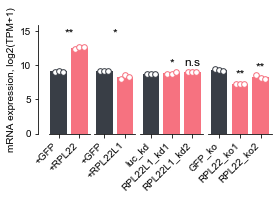

In [240]:
all_bars("ENSG00000116251","gene")

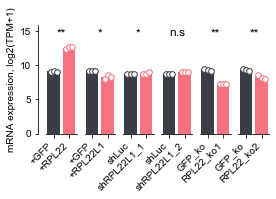

In [57]:
all_bars("ENSG00000116251","gene")

plt.savefig("../plots/RPL22_ENSG00000116251_expression.pdf",bbox_inches="tight",background="transparent")

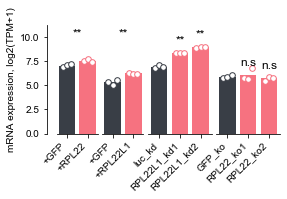

In [241]:
all_bars("ENSG00000135679","gene")


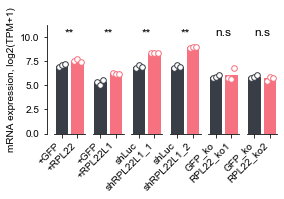

In [58]:
all_bars("ENSG00000135679","gene")

plt.savefig("../plots/MDM2_ENSG00000135679_expression.pdf",bbox_inches="tight",background="transparent")

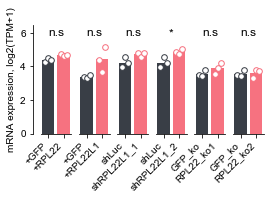

In [59]:
all_bars("ENSG00000198625","gene")

plt.savefig("../plots/MDM4_ENSG00000198625_expression.pdf",bbox_inches="tight",background="transparent")

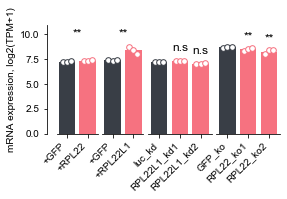

In [242]:
all_bars("ENSG00000143569","gene")

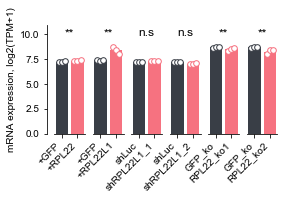

In [112]:
all_bars("ENSG00000143569","gene")

plt.savefig("../plots/UBAP2L_ENSG00000143569_expression.pdf",bbox_inches="tight",background="transparent")

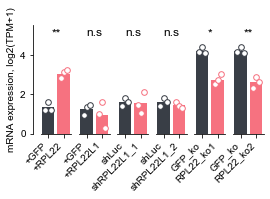

In [116]:
all_bars("ENST00000484819","transcript")

plt.savefig("../plots/UBAP2L_ENST00000484819_expression.pdf",bbox_inches="tight",background="transparent")

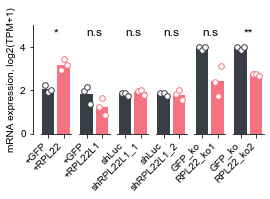

In [117]:
all_bars("ENST00000433615","transcript")

plt.savefig("../plots/UBAP2L_ENST00000433615_expression.pdf",bbox_inches="tight",background="transparent")

## Volcano plots

# Differential splicing

In [245]:
rpl22_oe_rmats = pd.read_csv("../data/processed/rmats_merge/rpl22_oe.txt",sep="\t",index_col=0)
rpl22l1_oe_rmats = pd.read_csv("../data/processed/rmats_merge/rpl22l1_oe.txt",sep="\t",index_col=0)
rpl22l1_kd1_rmats = pd.read_csv("../data/processed/rmats_merge/rpl22l1_kd1.txt",sep="\t",index_col=0)
rpl22l1_kd2_rmats = pd.read_csv("../data/processed/rmats_merge/rpl22l1_kd2.txt",sep="\t",index_col=0)
rpl22_ko1_rmats = pd.read_csv("../data/processed/rmats_merge/rpl22_ko1.txt",sep="\t",index_col=0)
rpl22_ko2_rmats = pd.read_csv("../data/processed/rmats_merge/rpl22_ko2.txt",sep="\t",index_col=0)

rpl22_oe_rmats = rpl22_oe_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22l1_oe_rmats = rpl22l1_oe_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22l1_kd1_rmats = rpl22l1_kd1_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22l1_kd2_rmats = rpl22l1_kd2_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22_ko1_rmats = rpl22_ko1_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22_ko2_rmats = rpl22_ko2_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)

splice_types = ["A3SS","A5SS","MXE","RI","SE"]

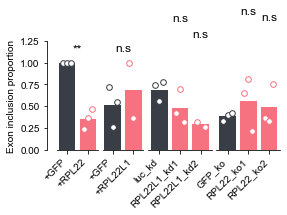

In [246]:
all_bars("UBAP2L_ENSG00000143569_154241837_154241888_154241232_154241430_154243356_154243649", 
     "splicing")

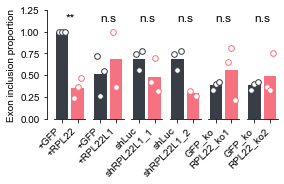

In [60]:
all_bars("UBAP2L_ENSG00000143569_154241837_154241888_154241232_154241430_154243356_154243649", 
     "splicing")

plt.savefig("../plots/UBAP2L_splicing.pdf",bbox_inches="tight",background="transparent")

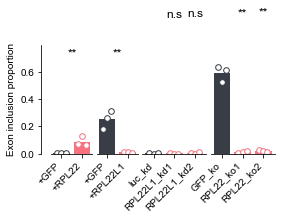

In [247]:
axes = all_bars("RPL22L1_ENSG00000163584_170585801_170585990_170585801_170585923_170586086_170586176", 
     "splicing")

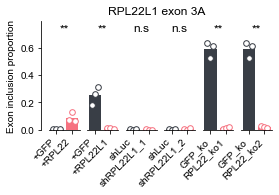

In [65]:
axes = all_bars("RPL22L1_ENSG00000163584_170585801_170585990_170585801_170585923_170586086_170586176", 
     "splicing")
plt.suptitle("RPL22L1 exon 3A")

plt.savefig("../plots/RPL22L1_3A_splicing.pdf",bbox_inches="tight",background="transparent")

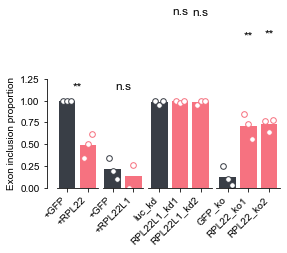

In [248]:
axes = all_bars("MDM4_ENSG00000198625_204506557_204506625_204501318_204501374_204507336_204507436", 
     "splicing")

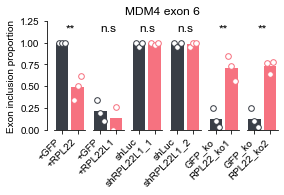

In [70]:
axes = all_bars("MDM4_ENSG00000198625_204506557_204506625_204501318_204501374_204507336_204507436", 
     "splicing")

plt.suptitle("MDM4 exon 6")
plt.savefig("../plots/MDM4_6_splicing.pdf",bbox_inches="tight",background="transparent")

## Splicing types

In [41]:
def plot_splice_types(rmats_diffs, qval_cutoff=0.01, ax=None,legend=False):
    
    if ax is None:
        ax = plt.subplot(111)

    significants = rmats_diffs.copy(
        deep=True)[rmats_diffs["qval"] < qval_cutoff]

    significants["treatment_increase"] = significants["treatment_median"] > significants["control_median"]

    significants["treatment_increase"] = significants["treatment_increase"].replace({True: "Inclusion",
                                                                                     False: "Exclusion"})

    significants = significants.groupby(
        "splice_type")["treatment_increase"].value_counts()
    significants = significants.unstack()

    significants, _ = significants.align(
        pd.Series(index=splice_types), join="right", axis=0)
    significants = significants.fillna(0)

    significants["splice_type"] = significants.index
    
    significants.columns.name = ""
    
    significants.plot(x="splice_type",
                      y=["Exclusion", "Inclusion"],
                      kind="bar",
                      cmap=mpl.colors.ListedColormap(
                          ["#dbe2ef", "#3f72af"]),
                      ax=ax,
                      stacked=True,
                      width=0.5,
                      legend=legend
                      )
    
    plt.ylabel("Frequency")
    plt.xlabel("Splice type")
    
    plt.xticks(rotation=45,ha="right")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines['left'].set_position(('axes', -0.05))

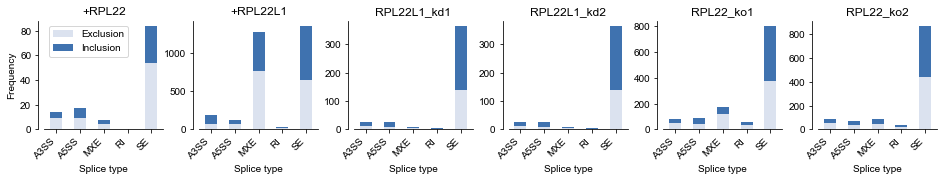

In [249]:
plt.figure(figsize=(16,2))
    
for experiment_idx, experiment in enumerate([rpl22_oe_rmats,
                                             rpl22l1_oe_rmats,
                                             rpl22l1_kd1_rmats,
                                             rpl22l1_kd1_rmats,
                                             rpl22_ko1_rmats,
                                             rpl22_ko2_rmats
                                            ]):

    ax = plt.subplot(1,6,experiment_idx+1)
    plot_splice_types(experiment,ax=ax,legend=experiment_idx<1)
    
    if experiment_idx > 0:
        plt.ylabel("")
        
    ax.set_title(display_names[experiment_idx])
        
plt.subplots_adjust(wspace=0.3)

plt.savefig("../plots/significant_splice_types.pdf",bbox_inches="tight",background="transparent")

# fgsea results

In [884]:
rpl22_oe_fgsea = pd.read_csv("../data/processed/fgsea_results/rpl22_oe.txt",sep="\t",index_col=0)
rpl22l1_oe_fgsea = pd.read_csv("../data/processed/fgsea_results/rpl22l1_oe.txt",sep="\t",index_col=0)
sh704_fgsea = pd.read_csv("../data/processed/fgsea_results/sh704.txt",sep="\t",index_col=0)
sh705_fgsea = pd.read_csv("../data/processed/fgsea_results/sh705.txt",sep="\t",index_col=0)

def preprocess_fgsea(fgsea):
    fgsea.sort_values(by="padj",inplace=True)
    fgsea.index = fgsea["pathway"]
    fgsea["gene_set"] = fgsea["pathway"].str.split("_").str[0]
    fgsea["direction"] = fgsea["NES"] > 0
    
preprocess_fgsea(rpl22_oe_fgsea)
preprocess_fgsea(rpl22l1_oe_fgsea)
preprocess_fgsea(sh704_fgsea)
preprocess_fgsea(sh705_fgsea)

In [1089]:
def get_top_n(fgsea, n=4):
#     positives = fgsea[fgsea["direction"]==True].head(n)
#     negatives = fgsea[fgsea["direction"]==False].head(n)

    return fgsea.head(n*2)
    
#     return pd.concat([positives,negatives],axis=0).sort_values(by="pval")

rpl22_oe_fgsea_top = get_top_n(rpl22_oe_fgsea)
rpl22l1_oe_fgsea_top = get_top_n(rpl22l1_oe_fgsea)
sh704_fgsea_top = get_top_n(sh704_fgsea)
sh705_fgsea_top = get_top_n(sh705_fgsea)

In [1109]:
fgsea = rpl22l1_oe_fgsea_top


def plot_top(fgsea_top, ax=None, legend=False):

    if ax is None:

        ax = plt.subplot(111)

    g = sns.scatterplot(
        -np.log10(fgsea_top["padj"]),
        np.arange(8),
        size=fgsea_top["size"].rename("Gene set size"),
        hue=(fgsea_top["NES"] > 0).replace(
            {True: "Upregulated", False: "Downregulated"}).rename("Expression change,\ntreatment"),
        sizes=(40, 250),
        size_norm=(0, 500),
        palette={"Upregulated": "#3f72af", "Downregulated": "#e23e57"},
        ax=ax,
        legend=legend
    )
    
    if legend:
        g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)   

    ax.set_xlim(0, plt.xlim()[1]*1.1)


    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.spines['bottom'].set_position(('axes', -0.025))
    ax.spines['left'].set_position(('axes', -0.05))

    ax.set_xlabel("-log10(q-value)")
    ax.set_yticks(np.arange(8))
    
    ylabels = fgsea_top["pathway"].apply(
        lambda x: x.replace("_", " ").capitalize())
    
    ylabels = ylabels.apply(lambda x: x.replace("Go ","").replace(" process","").capitalize())
    
    ax.set_yticklabels(ylabels)

    return ax

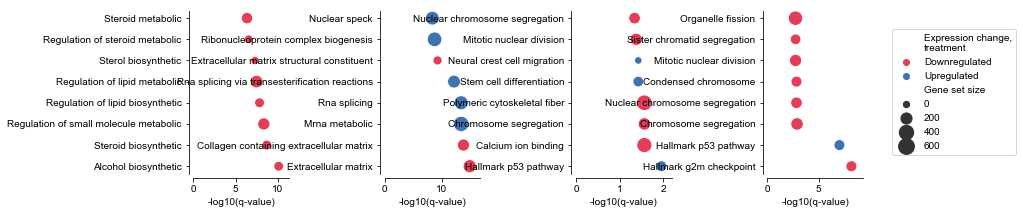

In [1110]:
plt.figure(figsize=(12,3))
plot_top(rpl22_oe_fgsea_top,plt.subplot(141))
plot_top(rpl22l1_oe_fgsea_top,plt.subplot(142))
plot_top(sh704_fgsea_top,plt.subplot(143))
plot_top(sh705_fgsea_top,plt.subplot(144),legend='brief')

plt.subplots_adjust(wspace=1)

plt.savefig("../plots/fgsea_top.pdf",bbox_inches="tight",background="transparent")